# Milestone Poject 2 : skimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here : https://arxiv.org/abs/1710.06071
        
And reading through the paper above, we see that the model architecture that they use to achieve their best results is available : https://arxiv.org/abs/1612.05251
        
*Resource :* If you want to find the ground truth for this notebook(with lots of diagrams and text annotation) see the Github: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

In [31]:
# Confirm acces to GPU
!nvidia-smi

Wed Feb  1 22:12:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.00       Driver Version: 517.00       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   58C    P8     3W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get data

Since we'll be replicating the paper above (PubMed 200K RCT)? let's download the dataset they used,
We can do so from the authors GitHub : 

In [32]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
# Check what files are in the PubMed_20K dataset


fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [33]:
ls pubmed-rct

 Le volume dans le lecteur C n'a pas de nom.
 Le num‚ro de s‚rie du volume est 1A6B-64E7

 R‚pertoire de C:\Users\wjub\01workspace\TensorFlow Developer Certificate ZTM\partie_2\TensorFlow_Developer_Certificate_ZTM\09_SkimLit_nlp_milestone_project\pubmed-rct

30/01/2023  08:23    <DIR>          .
01/02/2023  22:12    <DIR>          ..
30/01/2023  08:23    <DIR>          PubMed_200k_RCT
30/01/2023  08:23    <DIR>          PubMed_200k_RCT_numbers_replaced_with_at_sign
30/01/2023  08:23    <DIR>          PubMed_20k_RCT
30/01/2023  08:23    <DIR>          PubMed_20k_RCT_numbers_replaced_with_at_sign
30/01/2023  08:23             2ÿ403 README.md
               1 fichier(s)            2ÿ403 octets
               6 R‚p(s)  430ÿ530ÿ322ÿ432 octets libres


In [34]:
ls pubmed-rct\PubMed_20k_RCT

 Le volume dans le lecteur C n'a pas de nom.
 Le num‚ro de s‚rie du volume est 1A6B-64E7

 R‚pertoire de C:\Users\wjub\01workspace\TensorFlow Developer Certificate ZTM\partie_2\TensorFlow_Developer_Certificate_ZTM\09_SkimLit_nlp_milestone_project\pubmed-rct\PubMed_20k_RCT

30/01/2023  08:23    <DIR>          .
30/01/2023  08:23    <DIR>          ..
30/01/2023  08:23         4ÿ962ÿ110 dev.txt
30/01/2023  08:23         4ÿ924ÿ980 test.txt
30/01/2023  08:23        29ÿ594ÿ141 train.txt
               3 fichier(s)       39ÿ481ÿ231 octets
               2 R‚p(s)  430ÿ530ÿ338ÿ816 octets libres


In [35]:
ls pubmed-rct\PubMed_20k_RCT_numbers_replaced_with_at_sign

 Le volume dans le lecteur C n'a pas de nom.
 Le num‚ro de s‚rie du volume est 1A6B-64E7

 R‚pertoire de C:\Users\wjub\01workspace\TensorFlow Developer Certificate ZTM\partie_2\TensorFlow_Developer_Certificate_ZTM\09_SkimLit_nlp_milestone_project\pubmed-rct\PubMed_20k_RCT_numbers_replaced_with_at_sign

30/01/2023  08:23    <DIR>          .
30/01/2023  08:23    <DIR>          ..
30/01/2023  08:23         4ÿ880ÿ409 dev.txt
30/01/2023  08:23         4ÿ846ÿ504 test.txt
30/01/2023  08:23        29ÿ118ÿ832 train.txt
               3 fichier(s)       38ÿ845ÿ745 octets
               2 R‚p(s)  430ÿ530ÿ338ÿ816 octets libres


In [36]:
# Start our experiments using the 20k dataset with numbers replaced by "#" sign
data_dir = "pubmed-rct\PubMed_20k_RCT_numbers_replaced_with_at_sign\\"

In [37]:
# Check all of the filenames in the target directory
import os
filenames= [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign\\dev.txt',
 'pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign\\test.txt',
 'pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign\\train.txt']

## Preprocess data 

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with data is to...

> Visualize, visualize, vizualize

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [38]:
# Create function to read lines of a document
def get_lines(filename):
    """
    Reads filename (a text filename) and returns the line of text as list.
    
    Args:
    	filename: a string containing the target filepath.
    Returns:
    	A list of strings with one string with one string per line from the target filename.  
    """
    with open(filename, "r") as f:
        return f.readlines()

In [39]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt")
train_lines[:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [40]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented.

```
[{'line_number':0,
	'target': 'BACKGROUND'?
    'text': "Emotional eating is associated with overeating and the development of obesity",
    'total_lines:11'}"]
```

In [41]:
def get_lines_data(filename):
    # Create an empty list to store processed lines
    result = []
    
    # Open the file in read mode
    with open(filename, "r") as f:
        # Read all lines of the file
        lines = f.readlines()
        # Initialize a counter to keep track of total lines
        total_lines = 0
        # Iterate over each line in the file
        for line_number, line in enumerate(lines):
            # Check if the line starts with '###'
            if line.startswith("###"):
                # If yes, reset the total_lines counter
                total_lines = 0
            else:
                # If not, increment the total_lines counter
                total_lines += 1
            # Split the line using '\t' as a separator
            split_line = line.split("\t")
            # Check if the split line has at least two parts
            if len(split_line) >= 2:
                # Extract the target and text from the split line
                target = split_line[0]
                text = split_line[1].replace("\n", "").strip()
                # Add the processed line as a dictionary to the result list
                result.append({
                    'line_number': line_number-1,
                    'target': target,
                    'text': text,
                    'total_lines': total_lines
                })
    # Return the list of processed lines
    return result





In [53]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.
  
  Args:
      filename: a string containing the target filepath to read.
  
  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [45]:
filename = data_dir+"train.txt"
target = "BACKGROUND"
get_lines_data(filename)[:20]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'total_lines': 1},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 2},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 3},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 4},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'Secondary outcome measures included th

In [75]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data.
    
    Take in filename, read it contents and sorts through each line, extracting things like the 
    target label, the text of the sentences, how many sentences are in the current abstract and 
    what sentence number the target line is.
    """
    input_lines = get_lines(filename) # get all lines from filename
    abstract_lines = "" # create an empty abstract
    # Loop through each line in the target file
    abstract_samples = []
    for line in input_lines:
        if line.startswith("###"): # check to see if the line is an ID line
            abstract_id  = line
            abstract_lines = "" # reset the abstract string if the line is an ID line

        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # Create an empty dictionnary
                target_text_split = abstract_line.split("\t")   
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower()
                line_data["line_number"] = abstract_line_number  
                line_data["total_lines"] = len(abstract_line_split) - 1
                abstract_samples.append(line_data) # add line data to abstract samples list
        else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
            abstract_lines += line
    return abstract_samples

In [76]:
# Get data from file and preprocess it 
%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

CPU times: total: 0 ns
Wall time: 0 ns
180040 30212 30135


Now that our data is the frormat of a list of ditionaries, how about we turn it into dataframe to futher visualize it?

In [91]:
# check the first abstract_line
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(train_samples)
train_df["target"] = numeric_labels
train_df

,target,text,line_number,total_lines
0,3,to investigate the efficacy of @ weeks of dail...,0,11
1,2,a total of @ patients with primary knee oa wer...,1,11
2,2,outcome measures included pain reduction and i...,2,11
3,2,pain was assessed using the visual analog pain...,3,11
4,2,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,4,for the absolute change in percent atheroma vo...,7,11
180036,4,"for pav , a significantly greater percentage o...",8,11
180037,4,both strategies had acceptable side effect pro...,9,11
180038,1,"compared with standard statin monotherapy , th...",10,11


In [84]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

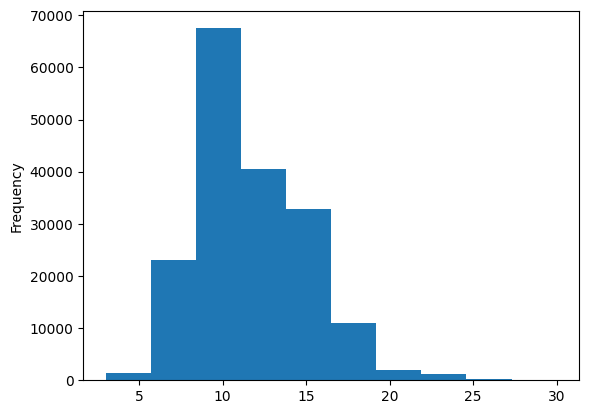

In [85]:
# let's check length of different lines
train_df.total_lines.plot.hist()

### Get lists of senteces

In [86]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)


(180040, 180040, 180040)

In [87]:
# View the 10 lines o ftraining sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [92]:
# One hot encode labels
from sklearn.preprocessing import LabelEncoder
train_df["target"]
encoder = LabelEncoder()
encoder.fit(train_df["target"])
numeric_labels = encoder.transform(train_df["target"])
print(numeric_labels)

[3 2 2 ... 4 1 1]


In [99]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))

# check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [98]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

###  Label encode labels

In [111]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"])
val_labels_encoded = label_encoder.fit_transform(val_df["target"])
test_labels_encoded = label_encoder.fit_transform(test_df["target"])

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1], dtype=int64)

In [112]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
# how build model 0 : naive baise
# use the training sentences to train on 
# you will to create tf.idf vectorizer